# Evaluating Different Similarity Metrics for A CBIR System
This work is aimed at demonstrating how the choice of different similarity metrics change the results of a Content-Based Image Retrieval Sytem. Below is the workflow:
- Given a database of images, extract and index the features.
- Based on a query image from a user, retrieve the top matched images based on specified similarity metric.
- Display the results and make comparison.

In [1]:
# libraries that are needed
import cv2
import shutil
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns; sns.set_theme();

from pathlib import Path

## Dataset: Corel Images Subset
For this project, I am going to use a very small subset of corel images database from kaggle. Here is the link to download the database [corel_images](https://www.kaggle.com/datasets/elkamel/corel-images/download?datasetVersionNumber=1). The dataset is in typical classifcation format, but I want all the images to be in one folder. Let's do that

In [62]:
corelimages_path = Path('corel_images')
dataset_path = Path('../datasets/corel_images_all/')
for path in corelimages_path.rglob('*'):
    if path.is_file():
        shutil.copy(path, dataset_path)
print(f'INFO: Dataset is ready...')

INFO: Dataset is ready...


## Implementation
We will extract feature descriptors for all images in the database and then we store them so that we don't have to calculate them over and over. After that we will perform image retrieval based on a query image.

In [50]:
def get_feature_descriptors(image_path, algorithm='sift'):
    """Computes feature descriptors for the given image using
    the specified algorithm"""
    if algorithm.lower() == 'sift':
        detector = cv2.SIFT_create()
    elif algorithm.lower() == 'orb':
        detector = cv2.ORB_create()
    else:
        print(f'Invalid algorithm ({algorithm}) for detecting features!')
        return
    image = cv2.imread(str(image_path), 0)
    keypoints, descriptors = detector.detectAndCompute(image, None)
    return descriptors

In [51]:
# loading images from the database and finding feature descriptors
images = [image for image in dataset_path.iterdir()]
all_descriptors = {}
for image in images:
    descriptors = get_feature_descriptors(image, algorithm='sift')
    if descriptors is not None:
        all_descriptors[str(image)] = descriptors

error: OpenCV(4.9.0) D:\bld\libopencv_1708670148202\work\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


In [26]:
# saving feature descriptors
with open('descriptors_sift.pkl', 'wb') as f:
    pickle.dump(all_descriptors, f)

In [27]:
# loading feature descriptors
with open('descriptors_sift.pkl', 'rb') as f:
    db_images_descriptors = pickle.load(f)

## Image Matching and Ranking
Now, using a test image we will query our system to find similar images and rank them with the best match coming first.

In [40]:
query_image = 'test.jpg'
query_descriptors = get_feature_descriptors(query_image, algorithm='sift')
len(query_descriptors)

217

In [46]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
similar_images = []
for image, descriptors in db_images_descriptors.items():
    matches = matcher.knnMatch(query_descriptors, descriptors, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    similar_images.append((image, good_matches))
similar_images.sort(key=lambda x: len(x[1]), reverse=True)

## Image Retrieval and Display
Now we will retrieve top 20 images and visualize them in a grid.

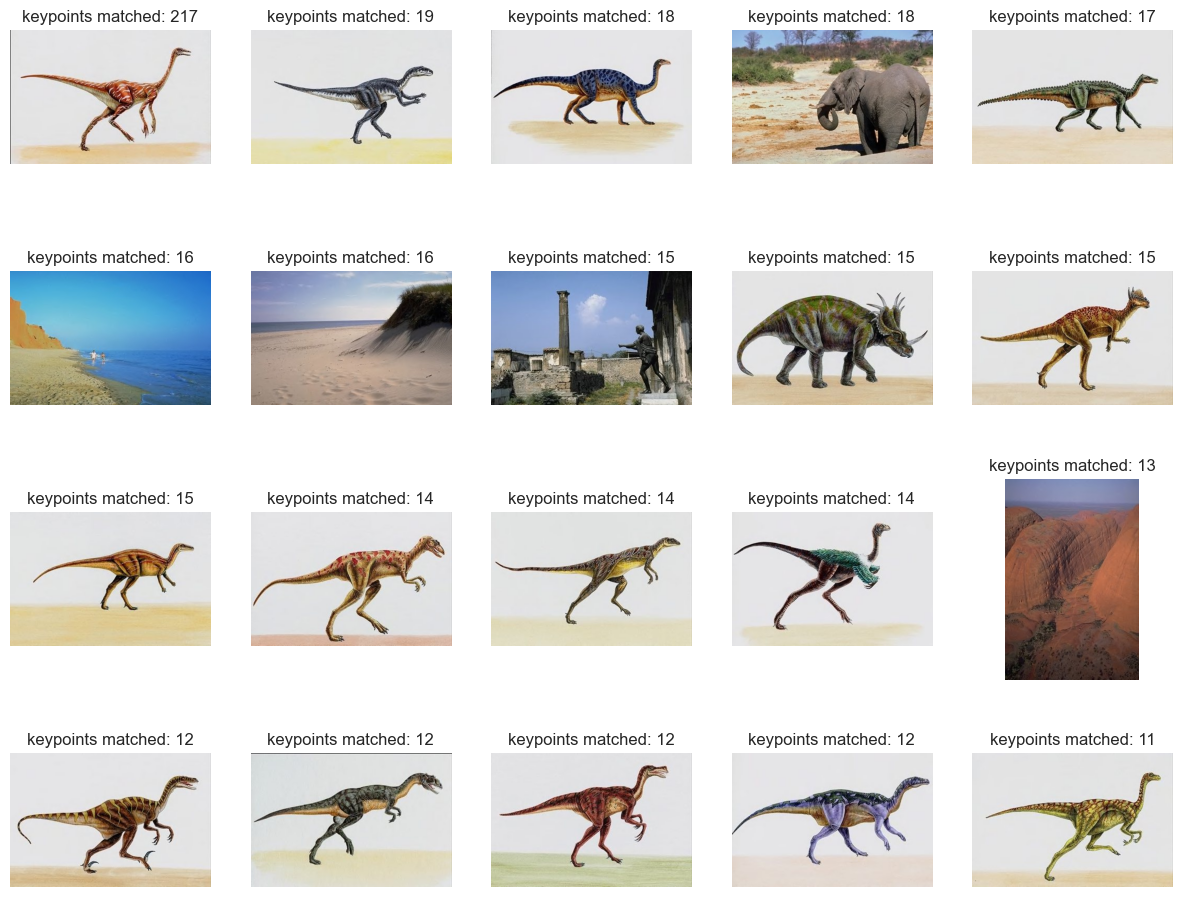

In [47]:
plt.figure(figsize=(15, 12))
for i, (image_path, matches) in enumerate(similar_images[:20]):
    plt.subplot(4, 5, i+1)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.title(f'keypoints matched: {len(matches)}')
    plt.axis('off')
plt.show()